# TODO

- EDA (correlation matrix) ; fouskakis 
- Feature extraction
- try classifiers 
- grid search -> find best 
- further research -> kaggle notebooks

Links<br>
https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators

https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf

https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system/data

https://www.cdc.gov/pcd/issues/2019/19_0109.htm

https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook

# Imports

In [95]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import matplotlib.pyplot as plt

In [2]:
path = 'Data/'
RAND_STATE = 42

In [3]:
inputs = pd.read_csv(path + 'diabetes_012_health_indicators_BRFSS2015.csv')

0: no diabetes
1: prediabetes
2: diabetes

# Preprocessing

In [45]:
class preprocessing():
    
    def __init__(self, raw):
        self.data = raw.copy()
        self.label_name = 'Diabetes_012'
        
    def convert_type(self):
        for col in self.data:
            self.data[col] = self.data[col].astype(int)
            
    def extract_labels(self):
        self.labels = self.data[[self.label_name]].to_numpy().flatten()
        
    def class_frequencies(self):
        _ , self.class_samples = np.unique(self.labels, return_counts=True)
        self.class_freq = self.class_samples/len(self.data)
#         if as_pct==True:
#             print(self.class_freq)
#         else:
#             print(self.class_samples)
    
    def remove_labels(self):
        self.data.drop([self.label_name], axis=1, inplace=True)
    
    def resample(self, T, num_samples):
        self.extract_labels()
        self.class_frequencies() 
        probs = np.exp((1 - self.class_freq) / T)
        probs /= probs.sum()
        self.data['sample_weight'] = self.data[self.label_name].map({0: probs[0], 1: probs[1], 2: probs[2]})
        self.data = self.data.sample(n=num_samples, replace=False, weights='sample_weight', random_state=RAND_STATE)
        self.data.drop(['sample_weight'], axis=1, inplace=True)
        
     # SMOTE 
        
    def equalize(self):
        tmp1 = self.data[self.data[self.label_name]==0].sample(n=4631, replace=False, random_state=RAND_STATE)
        tmp2 = self.data[self.data[self.label_name]==1].sample(n=4631, replace=False, random_state=RAND_STATE)
        tmp3 = self.data[self.data[self.label_name]==2].sample(n=4631, replace=False, random_state=RAND_STATE)
        self.data = pd.concat([tmp1, tmp2, tmp3]).sample(frac=1, random_state = RAND_STATE)


In [46]:
def preprocessing_pipeline(resample, equalize, T=0.1, n_samples=50000):
    obj = preprocessing(inputs)
    obj.convert_type()
    if resample:
        obj.resample(T, n_samples)
    if equalize:
        obj.equalize()    
    obj.extract_labels()
    obj.class_frequencies()
    obj.remove_labels()
    return obj

In [6]:
without_resampling = preprocessing_pipeline(resample=False)

In [37]:
with_resampling = preprocessing_pipeline(resample=True, T=0.1, n_samples=50000)

In [47]:
equalized = preprocessing_pipeline(resample=False, equalize = True)

# Feature importances

In [102]:
def feature_importance(classifier):
    
    importance = classifier.clf.feature_importances_
    features   = classifier.train_data.columns.tolist()
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance)), importance, align='center')
    plt.yticks(range(len(importance)), features)  # Assuming 'features' is a list of feature names
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.show()

# Random Forest Classifier

In [59]:
class random_forest:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
#         self.train_data = None
#         self.test_data = None
#         self.train_labels = None
#         self.test_labels = None
        
    def split(self, test_size):
        train_data, test_data, train_labels, test_labels = train_test_split(self.data, 
                                                                        self.labels,
                                                                        test_size = test_size,
                                                                        random_state = RAND_STATE,
                                                                        stratify=self.labels)
        self.train_data = train_data
        self.test_data = test_data
        self.train_labels = train_labels
        self.test_labels = test_labels
    
    def train_clf(self):
        self.clf = RandomForestClassifier(random_state=RAND_STATE)
        self.clf.fit(self.train_data, self.train_labels)
        
    def predict(self):
        self.clf.score(self.test_data, self.test_labels)
        
    def classification_report(self):
        print(classification_report(self.test_labels, self.clf.predict(self.test_data)))
        

In [60]:
rf1 = random_forest(without_resampling.data, without_resampling.labels)
rf1.split(test_size=0.2)
rf1.train_clf()
rf1.classification_report()

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42741
           1       0.00      0.00      0.00       926
           2       0.49      0.20      0.28      7069

    accuracy                           0.84     50736
   macro avg       0.45      0.39      0.40     50736
weighted avg       0.80      0.84      0.81     50736



In [61]:
rf2 = random_forest(with_resampling.data, with_resampling.labels)
rf2.split(test_size=0.2)
rf2.train_clf()
rf2.classification_report()

              precision    recall  f1-score   support

           0       0.65      0.44      0.52      2005
           1       0.06      0.00      0.01       926
           2       0.78      0.94      0.85      7069

    accuracy                           0.76     10000
   macro avg       0.50      0.46      0.46     10000
weighted avg       0.69      0.76      0.71     10000



In [62]:
rf3 = random_forest(equalized.data, equalized.labels)
rf3.split(test_size=0.2)
rf3.train_clf()
rf3.classification_report()

              precision    recall  f1-score   support

           0       0.58      0.57      0.57       926
           1       0.40      0.37      0.38       926
           2       0.47      0.52      0.49       927

    accuracy                           0.48      2779
   macro avg       0.48      0.48      0.48      2779
weighted avg       0.48      0.48      0.48      2779



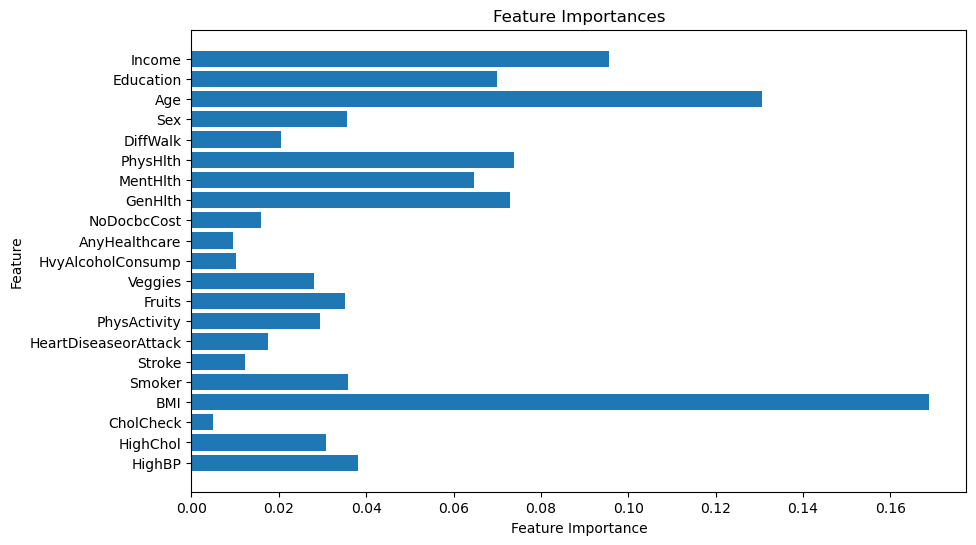

In [103]:
feature_importance(rf3)

# Gradient Boosting

In [69]:
class gradient_boosting:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
#         self.train_data = None
#         self.test_data = None
#         self.train_labels = None
#         self.test_labels = None
        
    def split(self, test_size):
        train_data, test_data, train_labels, test_labels = train_test_split(self.data, 
                                                                        self.labels,
                                                                        test_size = test_size,
                                                                        random_state = RAND_STATE,
                                                                        stratify=self.labels)
        self.train_data = train_data
        self.test_data = test_data
        self.train_labels = train_labels
        self.test_labels = test_labels
    
    def train_clf(self):
        self.clf = GradientBoostingClassifier(random_state=RAND_STATE, class_weights={0:0.5, 1:3, 2:1})
        self.clf.fit(self.train_data, self.train_labels)
        
    def predict(self):
        self.clf.score(self.test_data, self.test_labels)
        
    def classification_report(self):
        print(classification_report(self.test_labels, self.clf.predict(self.test_data)))

In [70]:
gb1 = random_forest(without_resampling.data, without_resampling.labels)
gb1.split(test_size=0.2)
gb1.train_clf()
gb1.classification_report()

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42741
           1       0.00      0.00      0.00       926
           2       0.49      0.20      0.28      7069

    accuracy                           0.84     50736
   macro avg       0.45      0.39      0.40     50736
weighted avg       0.80      0.84      0.81     50736



In [71]:
gb2 = random_forest(with_resampling.data, with_resampling.labels)
gb2.split(test_size=0.2)
gb2.train_clf()
gb2.classification_report()

              precision    recall  f1-score   support

           0       0.65      0.44      0.52      2005
           1       0.06      0.00      0.01       926
           2       0.78      0.94      0.85      7069

    accuracy                           0.76     10000
   macro avg       0.50      0.46      0.46     10000
weighted avg       0.69      0.76      0.71     10000



In [72]:
gb3 = random_forest(equalized.data, equalized.labels)
gb3.split(test_size=0.2)
gb3.train_clf()
gb3.classification_report()

              precision    recall  f1-score   support

           0       0.58      0.57      0.57       926
           1       0.40      0.37      0.38       926
           2       0.47      0.52      0.49       927

    accuracy                           0.48      2779
   macro avg       0.48      0.48      0.48      2779
weighted avg       0.48      0.48      0.48      2779



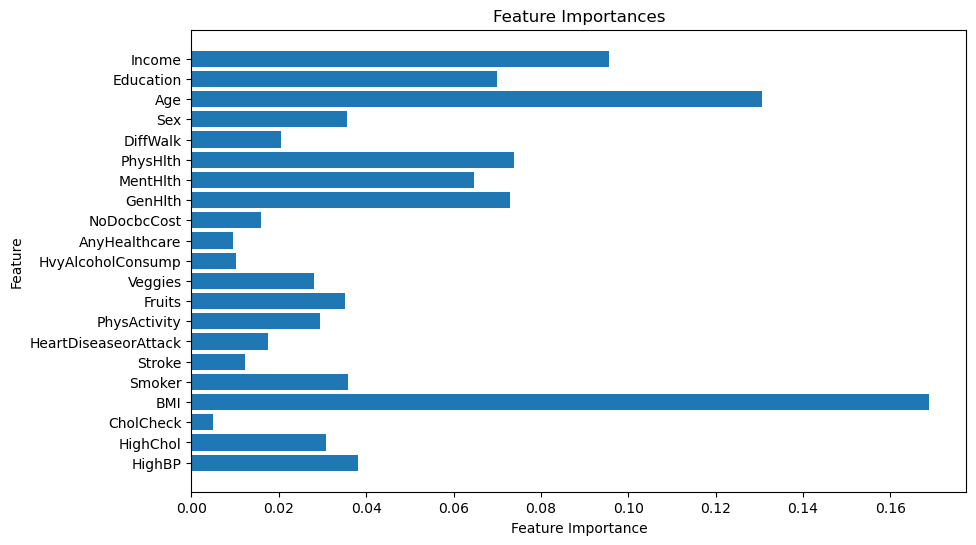

In [104]:
feature_importance(gb3)

# TODO

1. Add more columns from original unprocessed dataset
2. Explore classifiers
3. Explore ways to balance data
4. EDA
5. feature importance analysis / model explainability
6. 

In [105]:
inputs.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')